## Run the Self-Organizing Map
___

First, load the data

In [25]:
from astropy.io import fits
from astropy.table import Table

import numpy as np

In [26]:
#Load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr100_lms6_12_25jun2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

GAMA_vect_data.add_column(GAMA_vect_data['r_mag_err'], index = 4, name = 'surf_bright_r_err')

In [27]:
#Select the needed data
input_data = GAMA_vect_data['r_mag', 'gr_color', 'surf_bright_r']
input_stds = GAMA_vect_data['r_mag_err', 'gr_color_err', 'surf_bright_r_err']

input_labels = GAMA_vect_data['r_mag', 'gr_color', 'surf_bright_r', 'log_stellar_mass', 'redshift']

tuple_labels = input_labels.as_array()
list_labels = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

In [4]:
#Bin by redshift
redshift_thresh = 0.1
redshift_idx = input_labels[:, 1] < redshift_thresh

input_data = input_data[redshift_idx]
input_stds = input_stds[redshift_idx]
input_labels = input_labels[redshift_idx] 

___

Initialize the SOM

In [28]:
from mpdg_som import SelfOrganizingMap

In [29]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [36, 36] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.63 #used to adjust the learning rate function
kernel_spread = 8.06 #used to adjust the neighborhood function
maximum_steps = 25 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.1 #used to stop the SOM if termination = 'error thresh'

In [30]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [31]:
data_cut = 10000 #use up to this much of the data
randomized_idx = np.arange(0, len(input_data))
np.random.shuffle(randomized_idx)
randomized_idx = randomized_idx[:data_cut]

SOM.load_data(input_data[randomized_idx],
              variable_names = ['r_mag', 'gr_color', 'surf_bright_r'])
SOM.normalize_data()

SOM.load_standard_deviations(input_stds[randomized_idx])
SOM.normalize_standard_deviations()

SOM.data_statistics()

| Data statistics 
stat	r_mag	gr_color	surf_bright_r	
min	0.000	0.000	0.000	
max	1.000	1.000	1.000	
mean	0.773	0.677	0.543	
median	0.794	0.688	0.543	
std	0.107	0.125	0.103	

In [32]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
| Initial quantization error: 1.258


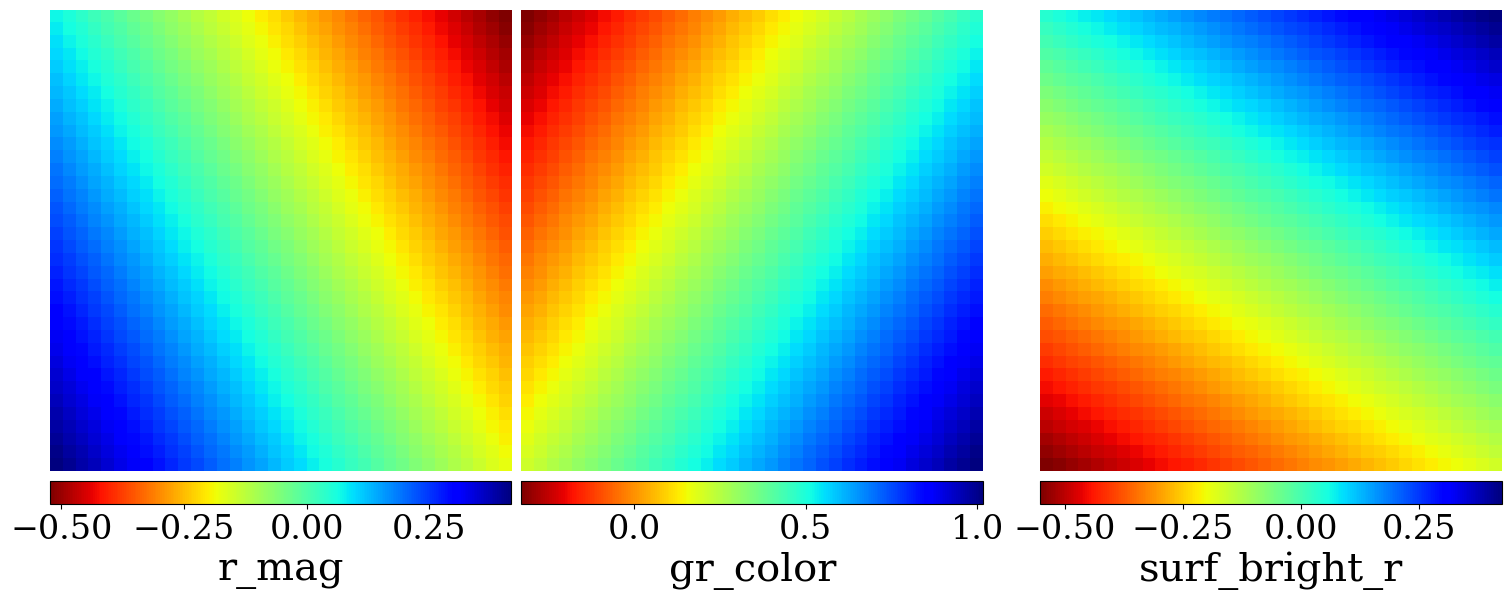

In [33]:
#Visualize SOM before training
SOM.show_map()

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'| Initial quantization error: {initial_quant_error:.3f}')

In [34]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.139
Step 2 complete. Error: 0.152
Step 3 complete. Error: 0.136
Step 4 complete. Error: 0.130
Step 5 complete. Error: 0.147
Step 6 complete. Error: 0.135
Step 7 complete. Error: 0.138
Step 8 complete. Error: 0.139


KeyboardInterrupt: 


| SOM. Step 8. Initialization: pca


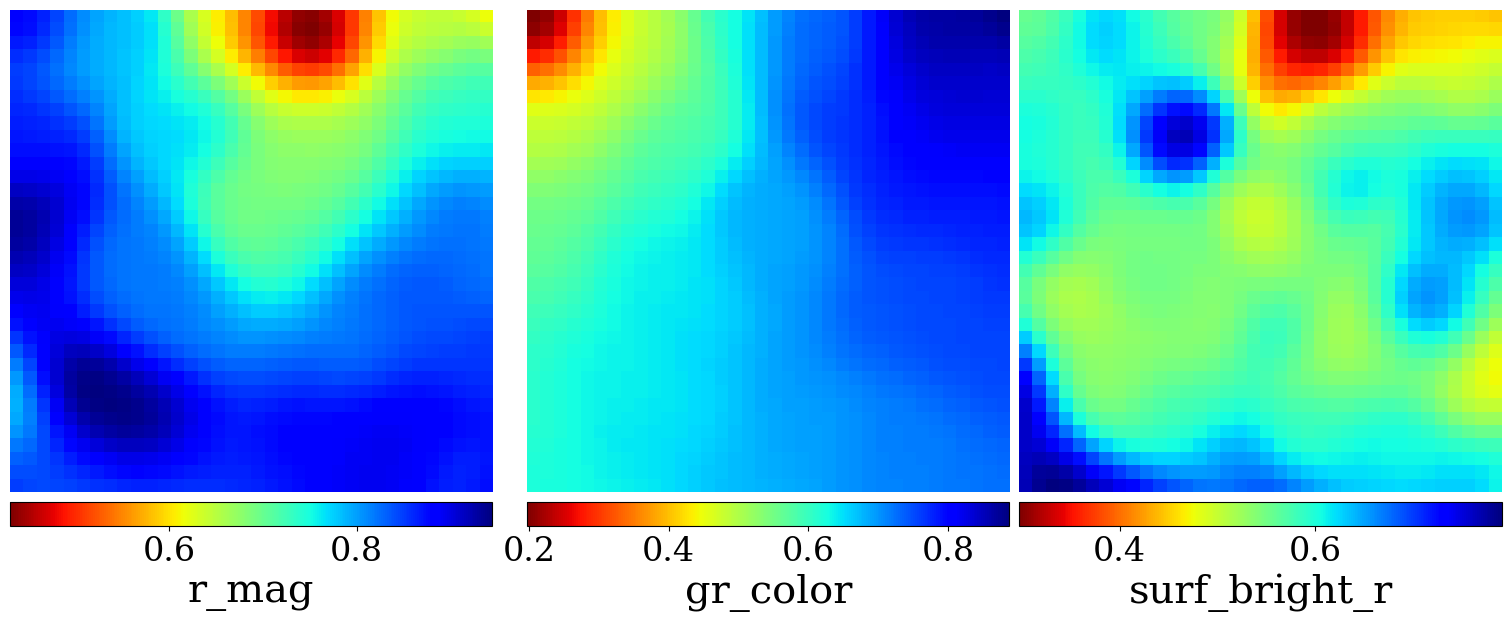

In [35]:
#Visualize the SOM after training
SOM.show_map()


| SOM. Step 8. Initialization: pca


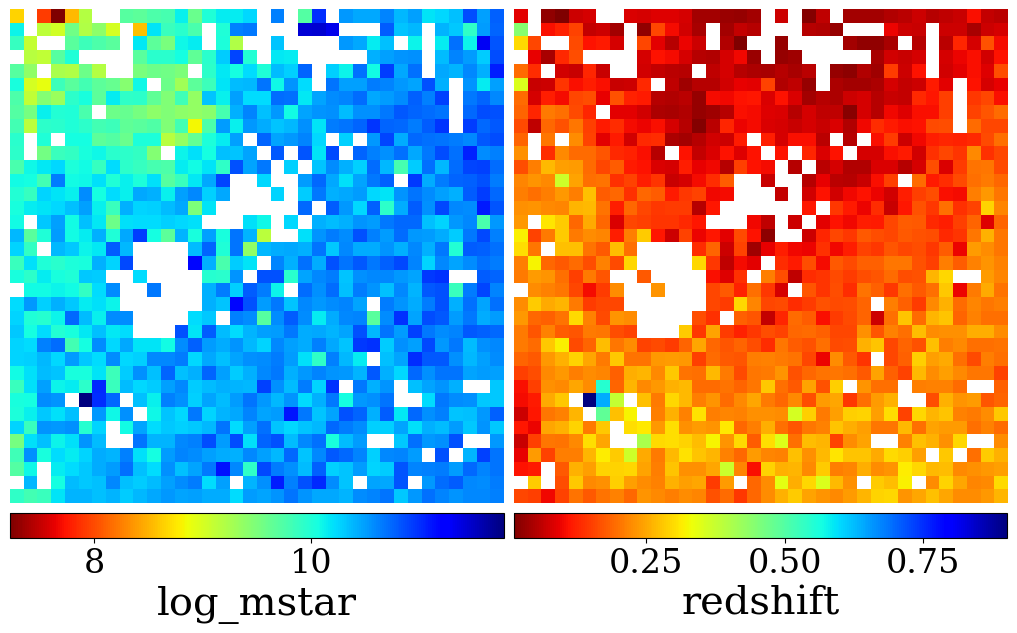

In [36]:
#Label the cells in the map with external parameters. Visualize the labeled map.
SOM.load_labeling_data(input_labels[:data_cut],
                       parameter_names = ['log_mstar', 'redshift'])
SOM.normalize_labeling_data()

SOM.label_map()

SOM.show_map(show_labeled = True)

In [37]:
cell_histogram = np.full(np.product(SOM.mapsize), np.nan)
for i, cell in enumerate(np.unique(SOM.bmu_indices, axis = 0)):
    cell_histogram[i] = np.sum(np.all(SOM.bmu_indices == cell, axis = -1))

In [38]:
np.nanmedian(cell_histogram)

7.0

In [39]:
SOM.predict(SOM.data)

array([[10.65848446,  0.14500999],
       [10.31448174,  0.20431   ],
       [10.34229755,  0.13125999],
       ...,
       [10.53753853,  0.10987499],
       [ 9.84828091,  0.13923   ],
       [10.80706978,  0.11042   ]])

___

Compare predictions to inputs

In [40]:
import matplotlib.pyplot as plt

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_430196/2633600844.py:15: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_430196/2633600844.py:16: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_430196/2633600844.py:20: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


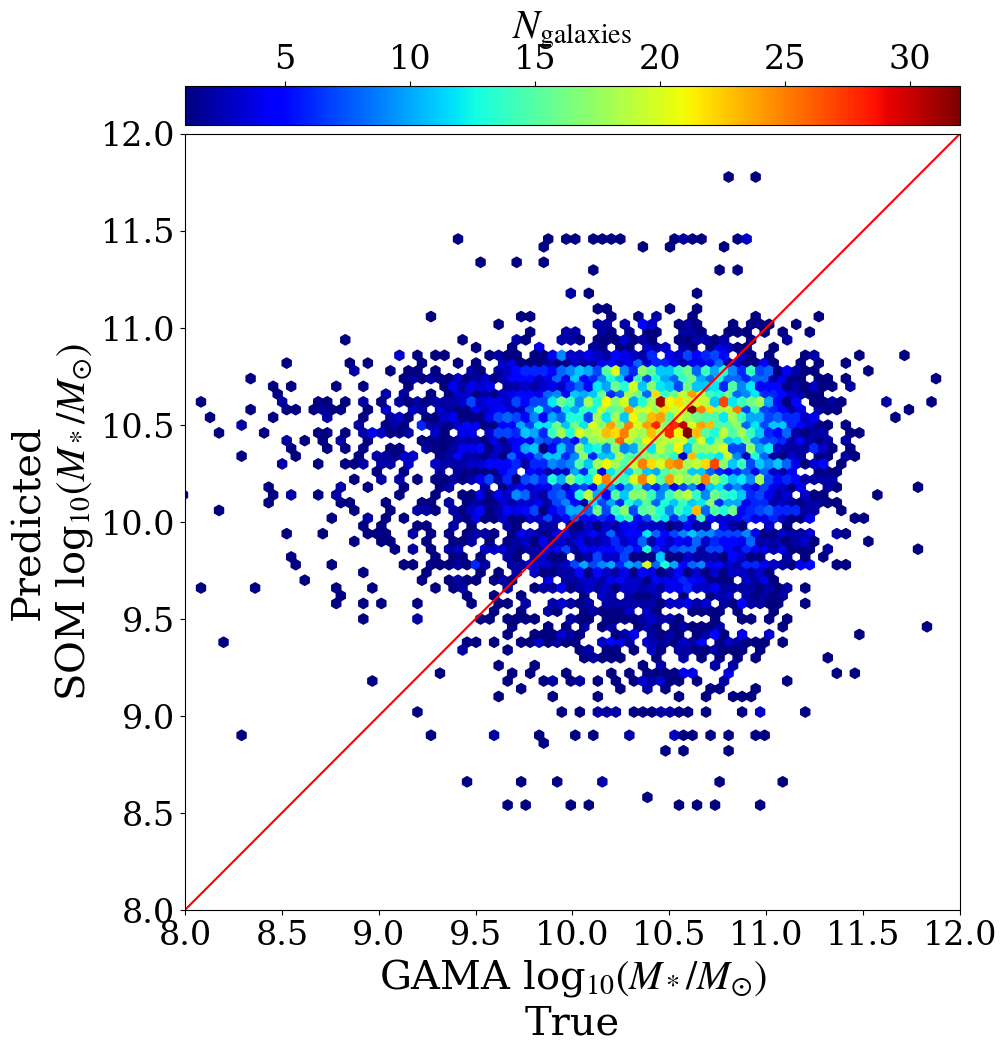

In [41]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)
ax.set_xticks(np.arange(8, 12.5, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_430196/645565033.py:19: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


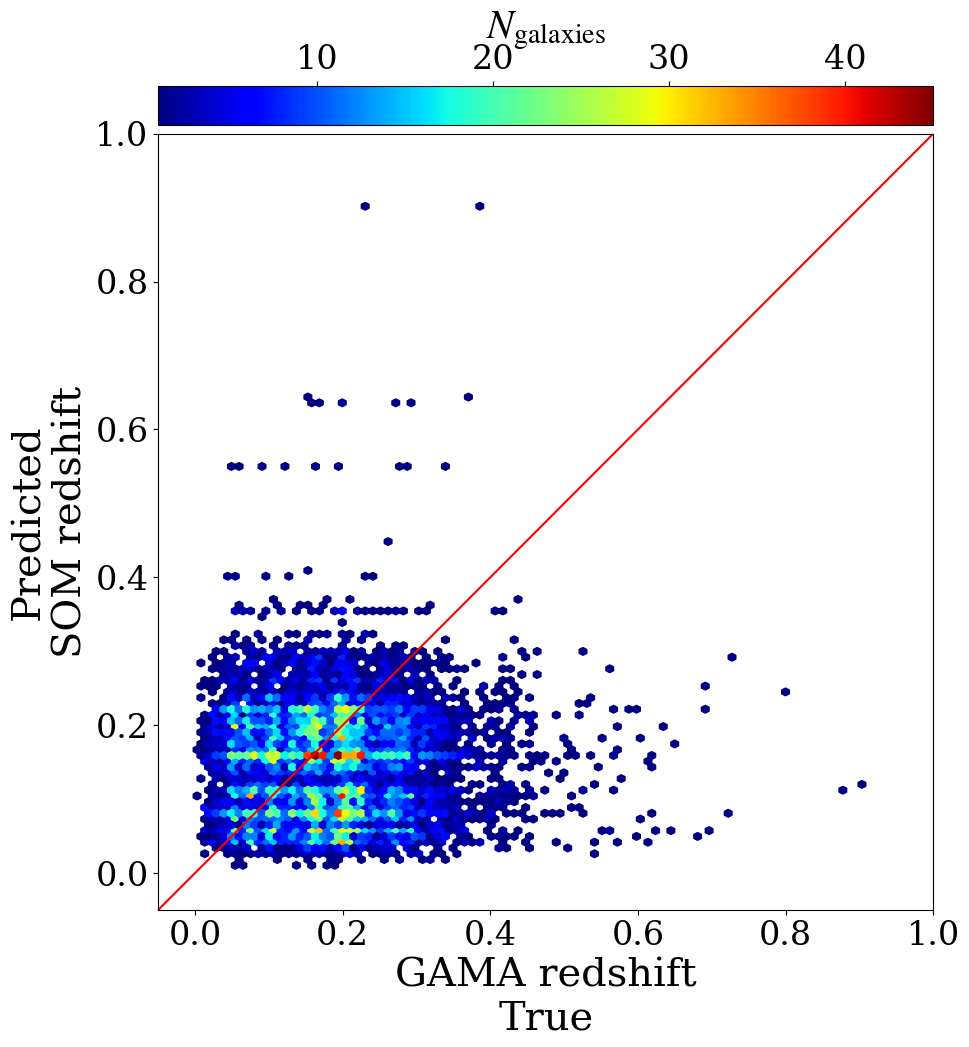

In [45]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.labeling_data[:, SOM.data_dim + 1],
               SOM.prediction_results[:, 1],
               mincnt = 1, cmap = 'jet')

ax.axline([0, 0], slope = 1, color = 'red')

ax.set_xlim(-0.05, 1)
ax.set_ylim(-0.05, 1)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')